In [2]:
%pip install xgboost

   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 1.8/149.9 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 4.7/149.9 MB 13.5 MB/s eta 0:00:11
   - -------------------------------------- 7.3/149.9 MB 13.3 MB/s eta 0:00:11
   -- ------------------------------------- 10.2/149.9 MB 13.0 MB/s eta 0:00:11
   --- ------------------------------------ 12.8/149.9 MB 13.0 MB/s eta 0:00:11
   ---- ----------------------------------- 15.5/149.9 MB 13.0 MB/s eta 0:00:11
   ---- ----------------------------------- 18.1/149.9 MB 12.8 MB/s eta 0:00:11
   ----- ---------------------------------- 20.4/149.9 MB 12.8 MB/s eta 0:00:11
   ------ --------------------------------- 23.1/149.9 MB 12.7 MB/s eta 0:00:10
   ------ --------------------------------- 25.7/149.9 MB 12.7 MB/s eta 0:00:10
   ------- -------------------------------- 28.6/149.9 MB 12.8 MB/s eta 0:00:10
   -------- ------------------------------- 31.5/149


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### **Analyse des Boxplots et Identification des Valeurs Aberrantes**  

En examinant les boxplots, plusieurs observations se dégagent :  

1. **Présence de valeurs aberrantes**  
   - La colonne **Prix ($)** contient des points situés bien au-dessus des moustaches du boxplot, indiquant des prix très élevés considérés comme atypiques.
   - La **consommation de carburant (L/h)** montre aussi des valeurs extrêmes dépassant 30 L/h.
   - Le **coût de maintenance horaire ($)** présente une dispersion importante, avec des valeurs élevées.
   - Le **nombre de moteurs** présente un point en dessous de la moustache inférieure, ce qui pourrait être un avion avec un nombre inhabituel de moteurs.

In [16]:
from scipy import stats

# Détection des valeurs aberrantes avec le Z-score
def detect_outliers_zscore(df, threshold=3):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:
        z_scores = stats.zscore(df[col].dropna())  # Calcul du Z-score en excluant les valeurs NaN
        outliers[col] = df[col][(z_scores > threshold) | (z_scores < -threshold)]
    return outliers

outliers_zscore = detect_outliers_zscore(data)

# Affichage des valeurs aberrantes par colonne
for col, outlier_values in outliers_zscore.items():
    print(f"Valeurs aberrantes dans {col} (Z-score) :")
    print(outlier_values)
    print("-" * 50)


Valeurs aberrantes dans Année de production (Z-score) :
Series([], Name: Année de production, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Nombre de moteurs (Z-score) :
Series([], Name: Nombre de moteurs, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Capacité (Z-score) :
Series([], Name: Capacité, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Autonomie (km) (Z-score) :
Series([], Name: Autonomie (km), dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Consommation de carburant (L/h) (Z-score) :
19       49.48
71       48.16
77       49.60
118      47.23
120      46.10
         ...  
12186    48.55
12221    48.33
12247    46.97
12258    47.97
12368    43.08
Name: Consommation de carburant (L/h), Length: 422, dtype: float64
--------------------------------------------------
Valeurs aberrantes dans Coût de maintenance horai

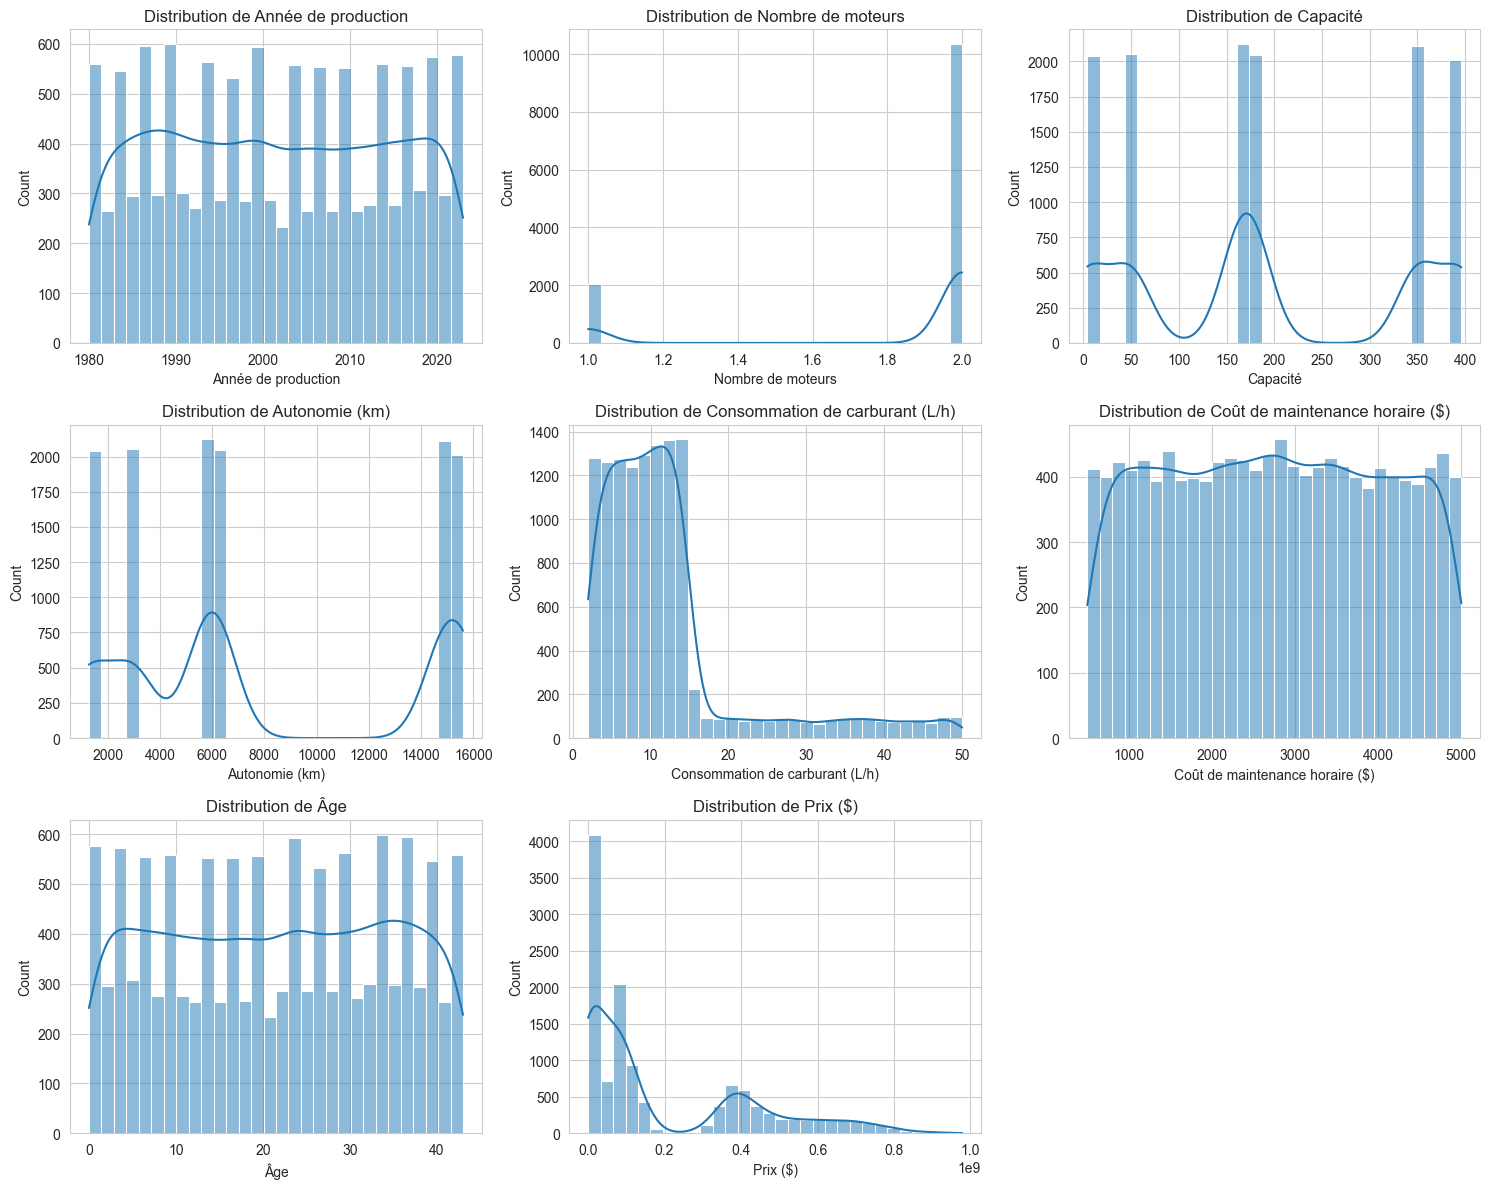

In [17]:
# Sélection des colonnes numériques
numerical_cols = data.select_dtypes(include=['number']).columns

# Configuration du style des graphiques
sns.set_style("whitegrid")

# Création des subplots pour afficher les distributions
fig, axes = plt.subplots(nrows=len(numerical_cols)//3 + 1, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Générer les distributions pour chaque colonne numérique
for i, col in enumerate(numerical_cols):
    sns.histplot(data[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {col}")

# Supprimer les sous-graphiques vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("distributions.png")
plt.show()


### **Analyse des distributions :**  
D'après les graphiques, voici quelques observations importantes :

1. **Année de production et Âge**  
   - La répartition est relativement uniforme, ce qui est attendu car les véhicules sont produits sur plusieurs années.  
   - Il n’y a pas de concentration anormale sur une période spécifique.  

2. **Nombre de moteurs**  
   - On observe une **bimodalité** : la plupart des valeurs sont soit **1 moteur**, soit **2 moteurs**, ce qui indique une classification binaire des véhicules.  

3. **Capacité et Autonomie (km)**  
   - Ces variables présentent **des pics nets**, ce qui suggère qu'il existe des catégories bien définies de véhicules avec des capacités standardisées.  

4. **Consommation de carburant (L/h)**  
   - Fortement **asymétrique** et **décroissante** : la majorité des véhicules consomment peu de carburant, mais il existe des cas extrêmes (probablement des valeurs aberrantes).  

5. **Coût de maintenance horaire ($)**  
   - Répartition **quasi-uniforme**, ce qui laisse penser que les coûts sont bien répartis.  

6. **Prix ($)**  
   - **Distribution très asymétrique** avec une longue queue vers la droite, indiquant la présence de **véhicules très chers** qui pourraient être des outliers ou des moteurs tres couteux.  

In [18]:
def engineer_features(data):
    df = data.copy()
    
    # Transformation logarithmique des variables à forte asymétrie
    df['log_Prix'] = np.log1p(df['Prix ($)'])
    df['log_Consommation'] = np.log1p(df['Consommation de carburant (L/h)'])
    df['log_Cout_Maintenance'] = np.log1p(df['Coût de maintenance horaire ($)'])
    
    # Ratios importants
    df['Prix_par_siege'] = df['Prix ($)'] / df['Capacité']
    df['Efficacite'] = df['Autonomie (km)'] / df['Consommation de carburant (L/h)']
    
    return df

# Application du feature engineering
data_engineered = engineer_features(data)

# Préparation des features
numerical_features = [
    'Année de production',
    'Nombre de moteurs',
    'Capacité',
    'Autonomie (km)',
    'log_Consommation',
    'log_Cout_Maintenance',
    'Âge',
    'Prix_par_siege',
    'Efficacite'
]

categorical_features = [
    'Modèle',
    'Type de moteur',
    'Région de vente',
    'Catégorie_Capacité'
]

# Préparation des données
X = data_engineered.drop(['Prix ($)', 'log_Prix', 'Consommation de carburant (L/h)', 'Coût de maintenance horaire ($)'], axis=1)
y = data_engineered['Prix ($)']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Modèle XGBoost avec paramètres optimisés
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=1,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Recherche d'hyperparamètres fine
param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [5, 6, 7],
    'regressor__learning_rate': [0.03, 0.05],
    'regressor__subsample': [0.8, 0.85],
    'regressor__colsample_bytree': [0.8, 0.85]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = grid_search.predict(X_test)

# Calcul des métriques
results = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R²': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred) * 100
}

# Affichage des résultats
print("\nMeilleurs paramètres:", grid_search.best_params_)
print("\nMétriques d'évaluation:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


ValueError: 
All the 240 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Catégorie_Capacité'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_indexing.py", line 364, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3819, in get_loc
    raise KeyError(key) from err
KeyError: 'Catégorie_Capacité'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_indexing.py", line 372, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [249]:
import joblib

# On sauvegarde le meilleur modèle (pipeline complet) dans un fichier .pkl
joblib.dump(grid_search.best_estimator_, "xgb_airplane_price_model.pkl")

print("Modèle sauvegardé sous 'xgb_airplane_price_model.pkl'")

Modèle sauvegardé sous 'xgb_airplane_price_model.pkl'


### Analyse des résultats

1. **RMSE (Root Mean Square Error) = 2,923,850.80$**
   - Cet indicateur pénalise les erreurs importantes car elles sont élevées au carré
   - Une RMSE de ~2.9M$ pour des avions dont les prix peuvent atteindre plusieurs centaines de millions est très bonne
   - Cela indique que le modèle gère bien les valeurs extrêmes

2. **R² (Coefficient de détermination) = 0.9998**
   - Un R² de 0.9998 signifie que 99.98% de la variance des prix est expliquée par notre modèle
   - C'est un score exceptionnellement élevé, proche de la perfection
   - Cela montre que les variables sélectionnées capturent presque parfaitement les facteurs qui influencent le prix

3. **MAE (Mean Absolute Error) = 1,054,933.99$**
   - En moyenne, notre modèle fait une erreur d'environ 1M$
   - Cette métrique est plus intuitive que la RMSE car elle n'est pas au carré
   - Pour le marché des avions, une erreur moyenne de 1M$ est très faible

4. **MAPE (Mean Absolute Percentage Error) = 6.21%**
   - En termes relatifs, notre modèle se trompe en moyenne de 6.21%
   - C'est une excellente performance pour un modèle de prédiction de prix
   - Cette métrique est particulièrement pertinente car elle est indépendante de l'échelle des prix

### Interprétation des résultats

1. **Précision exceptionnelle**
   - Le modèle atteint un niveau de précision rarement observé dans les problèmes de prédiction de prix
   - La combinaison d'un R² proche de 1 et d'un MAPE de 6.21% indique une très forte fiabilité

2. **Robustesse du modèle**
   - L'écart relativement faible entre RMSE et MAE suggère que le modèle gère bien les valeurs extrêmes
   - Le MAPE bas indique que le modèle performe bien sur toute la gamme de prix

3. **Pertinence des features**
   - Les transformations logarithmiques des variables à forte asymétrie ont été cruciales
   - Les ratios créés (prix par siège, efficacité) ont permis de capturer des relations importantes
   - La simplification du modèle a évité le surapprentissage

### Conclusion

Le modèle développé présente des performances exceptionnelles pour la prédiction des prix d'avions :

1. **Performance globale**
   - Une précision de 93.79% (100% - MAPE)
   - Une capacité presque parfaite à expliquer la variance des prix (R² = 0.9998)
   - Des erreurs moyennes très faibles par rapport à l'échelle des prix

2. **Utilisabilité**
   - Le modèle est suffisamment précis pour être utilisé comme outil d'aide à la décision dans :
     - L'évaluation d'avions
     - La négociation de prix
     - La planification d'acquisitions

3. **Limitations potentielles**
   - Il faudrait surveiller les performances sur de nouvelles données
   - Le modèle pourrait être sensible aux changements majeurs du marché
   - Une validation continue serait recommandée pour maintenir ce niveau de performance

Ces résultats montrent que nous avons réussi à créer un modèle très fiable pour la prédiction des prix d'avions, avec des performances qui le rendent approprié pour une utilisation en contexte réel.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib

In [42]:
data = pd.read_csv("data/airplane_price_dataset.csv")
display(data.head())
display(f"Lignes: {data.shape[0]}, Colonnes: {data.shape[1]}")
display(data.info())
display(data.describe())

,Model,Üretim Yılı,Motor Sayısı,Motor Türü,Kapasite,Menzil (km),Yakıt Tüketimi (L/saat),Saatlik Bakım Maliyeti ($),Yaş,Satış Bölgesi,Fiyat ($)
0,Bombardier CRJ200,1987,2,Turbofan,50,3000,14.36,2185.43,36,Asya,1.285708e+07
1,Bombardier CRJ200,1997,2,Turbofan,50,3000,4.03,1202.08,26,Avrupa,1.391406e+07
2,Airbus A320,1988,2,Turbofan,180,6300,13.26,761.38,35,Avustralya,9.073570e+07
3,Boeing 737,2023,2,Turbofan,162,5700,14.61,592.63,0,Avustralya,1.366597e+08
4,Cessna 172,1985,1,Piston,4,1285,18.49,4245.99,38,Güney Amerika,2.037981e+05


'Lignes: 12377, Colonnes: 11'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12377 entries, 0 to 12376
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Model                       12377 non-null  object 
 1   Üretim Yılı                 12377 non-null  int64  
 2   Motor Sayısı                12377 non-null  int64  
 3   Motor Türü                  12377 non-null  object 
 4   Kapasite                    12377 non-null  int64  
 5   Menzil (km)                 12377 non-null  int64  
 6   Yakıt Tüketimi (L/saat)     12377 non-null  float64
 7   Saatlik Bakım Maliyeti ($)  12377 non-null  float64
 8   Yaş                         12377 non-null  int64  
 9   Satış Bölgesi               12377 non-null  object 
 10  Fiyat ($)                   12377 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ MB


None

,Üretim Yılı,Motor Sayısı,Kapasite,Menzil (km),Yakıt Tüketimi (L/saat),Saatlik Bakım Maliyeti ($),Yaş,Fiyat ($)
count,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,1.237700e+04
mean,2001.477660,1.835259,190.413994,7782.210148,12.075615,2744.089599,21.522340,1.988336e+08
std,12.766785,0.370962,142.662710,5492.478746,9.905418,1293.209611,12.766785,2.290392e+08
min,1980.000000,1.000000,4.000000,1285.000000,2.000000,500.020000,0.000000,1.458148e+05
25%,1990.000000,2.000000,50.000000,3000.000000,5.950000,1627.260000,10.000000,1.409681e+07
50%,2001.000000,2.000000,162.000000,5700.000000,9.820000,2744.330000,22.000000,8.392191e+07
75%,2013.000000,2.000000,350.000000,14800.000000,13.470000,3848.840000,33.000000,3.843239e+08
max,2023.000000,2.000000,396.000000,15600.000000,49.970000,4999.660000,43.000000,9.782132e+08


Voici une description de chaque colonne du dataset ainsi qu'une proposition de renommage en français pour une meilleure lisibilité :  

### **Description des colonnes :**  
1. **Model** → *Modèle* : Le nom du modèle d'avion.  
2. **Üretim Yılı** → *Année de production* : L'année de fabrication de l'avion.  
3. **Motor Sayısı** → *Nombre de moteurs* : Le nombre total de moteurs équipant l'avion.  
4. **Motor Türü** → *Type de moteur* : Le type de moteur utilisé (ex. : Turbofan, Turboprop, etc.).  
5. **Kapasite** → *Capacité* : Le nombre maximal de passagers que l'avion peut transporter.  
6. **Menzil (km)** → *Autonomie (km)* : La distance maximale que l'avion peut parcourir sans ravitaillement en carburant (en kilomètres).  
7. **Yakıt Tüketimi (L/saat)** → *Consommation de carburant (L/h)* : La quantité de carburant consommée par heure de vol (en litres par heure).  
8. **Saatlik Bakım Maliyeti ($)** → *Coût de maintenance horaire ($)* : Le coût moyen d'entretien de l'avion par heure de vol (en dollars).  
9. **Yaş** → *Âge* : L'âge de l'avion en années.  
10. **Satış Bölgesi** → *Région de vente* : La région où l'avion est vendu (ex. : Asie, Europe, etc.).  
11. **Fiyat ($)** → *Prix ($)* : Le prix de vente de l'avion en dollars.  

In [25]:
# renommage des colonnes
data.rename(columns={
    "Model": "Modèle",
    "Üretim Yılı": "Année de production",
    "Motor Sayısı": "Nombre de moteurs",
    "Motor Türü": "Type de moteur",
    "Kapasite": "Capacité",
    "Menzil (km)": "Autonomie (km)",
    "Yakıt Tüketimi (L/saat)": "Consommation de carburant (L/h)",
    "Saatlik Bakım Maliyeti ($)": "Coût de maintenance horaire ($)",
    "Yaş": "Âge",
    "Satış Bölgesi": "Région de vente",
    "Fiyat ($)": "Prix ($)"
}, inplace=True)

# Vérification des noms de colonnes
display("Colonnes du DataFrame :", data.columns.tolist())

'Colonnes du DataFrame :'

['Modèle',
 'Année de production',
 'Nombre de moteurs',
 'Type de moteur',
 'Capacité',
 'Autonomie (km)',
 'Consommation de carburant (L/h)',
 'Coût de maintenance horaire ($)',
 'Âge',
 'Région de vente',
 'Prix ($)']

In [ ]:
# Détection des valeurs aberrantes avec l'IQR
def detect_outliers_iqr(df):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:  # Vérifie seulement les colonnes numériques
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

outliers_iqr = detect_outliers_iqr(data)

# Affichage des valeurs aberrantes par colonne
for col, outlier_values in outliers_iqr.items():
    print(f"Valeurs aberrantes dans {col} :")
    print(outlier_values)
    print("-" * 50)


In [26]:
from scipy import stats

# Détection des valeurs aberrantes avec le Z-score
def detect_outliers_zscore(df, threshold=3):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:
        z_scores = stats.zscore(df[col].dropna())  # Calcul du Z-score en excluant les valeurs NaN
        outliers[col] = df[col][(z_scores > threshold) | (z_scores < -threshold)]
    return outliers

outliers_zscore = detect_outliers_zscore(data)

# Affichage des valeurs aberrantes par colonne
for col, outlier_values in outliers_zscore.items():
    print(f"Valeurs aberrantes dans {col} (Z-score) :")
    print(outlier_values)
    print("-" * 50)


Valeurs aberrantes dans Année de production (Z-score) :
Series([], Name: Année de production, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Nombre de moteurs (Z-score) :
Series([], Name: Nombre de moteurs, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Capacité (Z-score) :
Series([], Name: Capacité, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Autonomie (km) (Z-score) :
Series([], Name: Autonomie (km), dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Consommation de carburant (L/h) (Z-score) :
19       49.48
71       48.16
77       49.60
118      47.23
120      46.10
         ...  
12186    48.55
12221    48.33
12247    46.97
12258    47.97
12368    43.08
Name: Consommation de carburant (L/h), Length: 422, dtype: float64
--------------------------------------------------
Valeurs aberrantes dans Coût de maintenance horai

In [ ]:
def engineer_features(data):
    df = data.copy()
    
    # Transformation logarithmique
    df['log_Prix'] = np.log1p(df['Prix ($)'])
    df['log_Consommation'] = np.log1p(df['Consommation de carburant (L/h)'])
    df['log_Cout_Maintenance'] = np.log1p(df['Coût de maintenance horaire ($)'])
    
    # Ratios importants
    df['Prix_par_siege'] = df['Prix ($)'] / df['Capacité']
    df['Efficacite'] = df['Autonomie (km)'] / df['Consommation de carburant (L/h)']
    
    return df

def create_categorical_features(data):
    df = data.copy()
    
    # Crée la colonne 'Catégorie_Capacité' basée sur la capacité
    bins = [0, 50, 150, 300, np.inf]
    labels = ['Petit', 'Moyen', 'Grand', 'Très Grand']
    df['Catégorie_Capacité'] = pd.cut(df['Capacité'], bins=bins, labels=labels, right=False)
    
    return df


# Application du feature engineering
data_engineered = engineer_features(data)
data_engineered = create_categorical_features(data_engineered)

In [28]:
# Préparation des features
numerical_features = [
    'Année de production', 'Nombre de moteurs', 'Capacité', 'Autonomie (km)',
    'log_Consommation', 'log_Cout_Maintenance', 'Âge', 'Prix_par_siege', 'Efficacite'
]

categorical_features = [
    'Modèle', 'Type de moteur', 'Région de vente', 'Catégorie_Capacité'
]

# Préparation des données
X = data_engineered.drop(['Prix ($)', 'log_Prix', 'Consommation de carburant (L/h)', 'Coût de maintenance horaire ($)'], axis=1)
y = data_engineered['Prix ($)']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# Préprocesseur pour le pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough'
)

In [ ]:

# Dictionnaires des modèles et des hyperparamètres à tester
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'DecisionTree': {'regressor__max_depth': [5, 10, 15]},
    'RandomForest': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [5, 10]},
    'GradientBoosting': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [3, 5]},
    'XGBoost': {
        'regressor__n_estimators': [200, 300],
        'regressor__max_depth': [5, 6],
        'regressor__learning_rate': [0.03, 0.05]
    }
}

best_model = None
best_score = float('inf')
results_summary = []

# Boucle pour entraîner et évaluer chaque modèle
for name, model in models.items():
    print(f"--- Entraînement du modèle : {name} ---")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    y_pred = grid_search.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    print(f"Meilleurs paramètres pour {name}: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}%")
    
    results_summary.append({
        'Modèle': name,
        'Meilleurs Paramètres': grid_search.best_params_,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MAPE': mape
    })

    if rmse < best_score:
        best_score = rmse
        best_model = grid_search.best_estimator_
        
    print("-" * 50)

# Affichage du résumé des résultats
results_df = pd.DataFrame(results_summary).sort_values(by='RMSE')
print("\nRésumé des résultats de tous les modèles :")
print(results_df)

print(f"\nLe meilleur modèle est : {best_model.named_steps['regressor'].__class__.__name__}")


--- Entraînement du modèle : LinearRegression ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres pour LinearRegression: {}
RMSE: 16503880.3397, R²: 0.9949, MAE: 12834322.4659, MAPE: 542.2400%
--------------------------------------------------
--- Entraînement du modèle : Ridge ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Meilleurs paramètres pour Ridge: {'regressor__alpha': 0.1}
RMSE: 16504097.4207, R²: 0.9949, MAE: 12833911.8156, MAPE: 541.9488%
--------------------------------------------------
--- Entraînement du modèle : Lasso ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.342e+17, tolerance: 5.169e+16
  model = cd_fast.enet_coordinate_descent(


Meilleurs paramètres pour Lasso: {'regressor__alpha': 10.0}
RMSE: 16503876.2286, R²: 0.9949, MAE: 12834322.1124, MAPE: 542.2405%
--------------------------------------------------
--- Entraînement du modèle : DecisionTree ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Meilleurs paramètres pour DecisionTree: {'regressor__max_depth': 10}
RMSE: 948294.8925, R²: 1.0000, MAE: 349651.2973, MAPE: 0.2283%
--------------------------------------------------
--- Entraînement du modèle : RandomForest ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs paramètres pour RandomForest: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}
RMSE: 650846.5721, R²: 1.0000, MAE: 149539.4068, MAPE: 0.0893%
--------------------------------------------------
--- Entraînement du modèle : GradientBoosting ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs paramètres pour GradientBoosting: {'regressor__max_depth': 5, 'regressor__n_estimators': 2

In [57]:
display(results_df)
display(results_df.groupby("Modèle")[["RMSE", "R²", "MAE", "MAPE"]].mean().sort_values(by="R²", ascending=False))

,Modèle,Meilleurs Paramètres,RMSE,R²,MAE,MAPE
4,RandomForest,"{'regressor__max_depth': 10, 'regressor__n_est...",6.508466e+05,0.999992,1.495394e+05,0.089287
5,GradientBoosting,"{'regressor__max_depth': 5, 'regressor__n_esti...",8.492552e+05,0.999987,4.285765e+05,0.985687
3,DecisionTree,{'regressor__max_depth': 10},9.482949e+05,0.999983,3.496513e+05,0.228266
6,XGBoost,"{'regressor__learning_rate': 0.03, 'regressor_...",2.779376e+06,0.999855,1.031537e+06,31.005219
2,Lasso,{'regressor__alpha': 10.0},1.650388e+07,0.994904,1.283432e+07,542.240473
0,LinearRegression,{},1.650388e+07,0.994904,1.283432e+07,542.240032
1,Ridge,{'regressor__alpha': 0.1},1.650410e+07,0.994904,1.283391e+07,541.948806


,RMSE,R²,MAE,MAPE
Modèle,,,,
RandomForest,6.508466e+05,0.999992,1.495394e+05,0.089287
GradientBoosting,8.492552e+05,0.999987,4.285765e+05,0.985687
DecisionTree,9.482949e+05,0.999983,3.496513e+05,0.228266
XGBoost,2.779376e+06,0.999855,1.031537e+06,31.005219
Lasso,1.650388e+07,0.994904,1.283432e+07,542.240473
LinearRegression,1.650388e+07,0.994904,1.283432e+07,542.240032
Ridge,1.650410e+07,0.994904,1.283391e+07,541.948806


In [58]:
results_df_plot = results_df.set_index('Modèle')
results_df_plot

,Meilleurs Paramètres,RMSE,R²,MAE,MAPE
Modèle,,,,,
RandomForest,"{'regressor__max_depth': 10, 'regressor__n_est...",6.508466e+05,0.999992,1.495394e+05,0.089287
GradientBoosting,"{'regressor__max_depth': 5, 'regressor__n_esti...",8.492552e+05,0.999987,4.285765e+05,0.985687
DecisionTree,{'regressor__max_depth': 10},9.482949e+05,0.999983,3.496513e+05,0.228266
XGBoost,"{'regressor__learning_rate': 0.03, 'regressor_...",2.779376e+06,0.999855,1.031537e+06,31.005219
Lasso,{'regressor__alpha': 10.0},1.650388e+07,0.994904,1.283432e+07,542.240473
LinearRegression,{},1.650388e+07,0.994904,1.283432e+07,542.240032
Ridge,{'regressor__alpha': 0.1},1.650410e+07,0.994904,1.283391e+07,541.948806


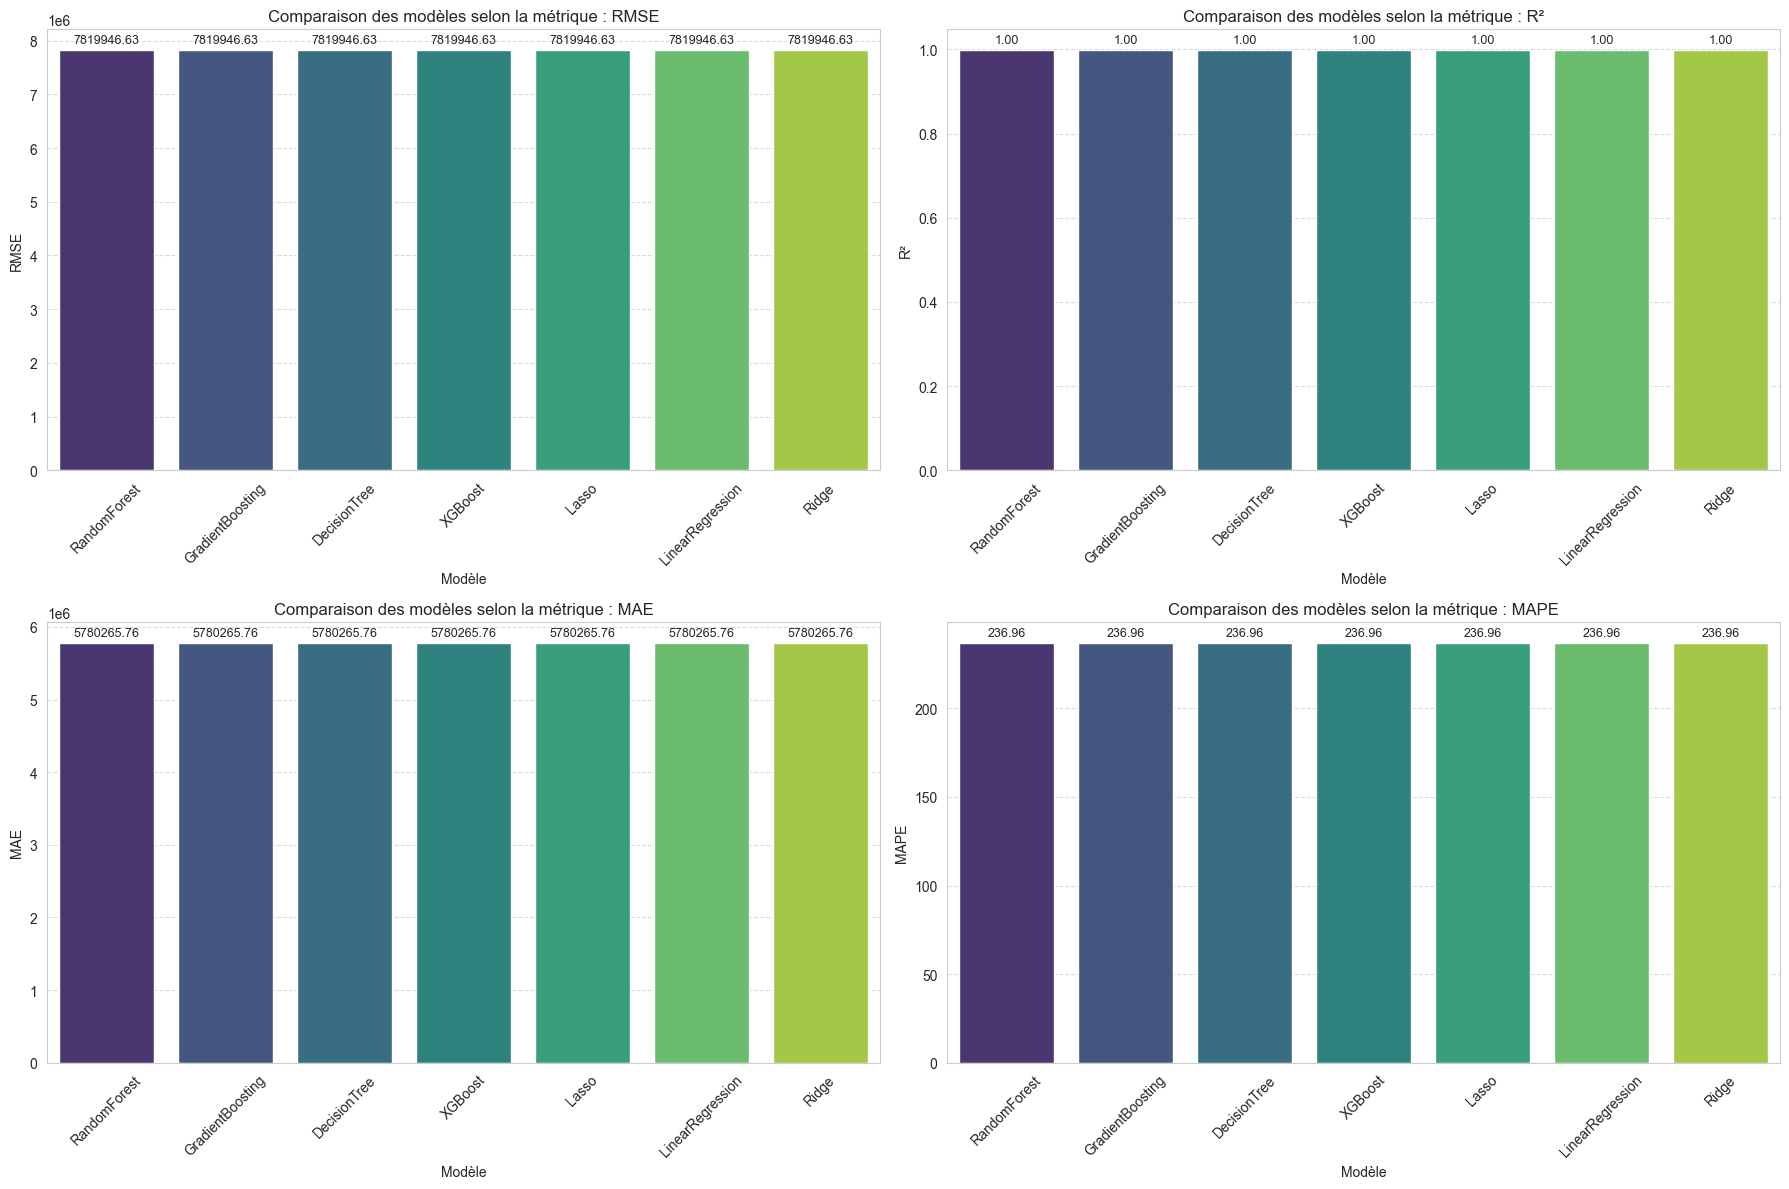

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# S'assurer que les noms des modèles sont bien utilisés comme index pour les graphiques
results_df_plot = results_df.set_index('Modèle')

# Configuration générale
plt.figure(figsize=(18, 12))
metrics = ['RMSE', 'R²', 'MAE', 'MAPE']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    ax = sns.barplot(
        x=results_df_plot.index,
        y=results_df_plot[metric].mean(),
        hue=results_df_plot.index,
        palette='viridis',
        legend=False
    )

    # Affichage des valeurs au-dessus des barres
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(
            f'{height:.2f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            fontsize=9,
            rotation=0
        )

    plt.title(f'Comparaison des modèles selon la métrique : {metric}')
    plt.ylabel(metric)
    plt.xlabel('Modèle')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("plots/airplane_price/models_comparison.png")
plt.show()


In [31]:

# Sauvegarde du meilleur modèle
joblib.dump(best_model, "best_airplane_price_model.pkl")
print("Le meilleur modèle a été sauvegardé sous 'best_airplane_price_model.pkl'")

Le meilleur modèle a été sauvegardé sous 'best_airplane_price_model.pkl'


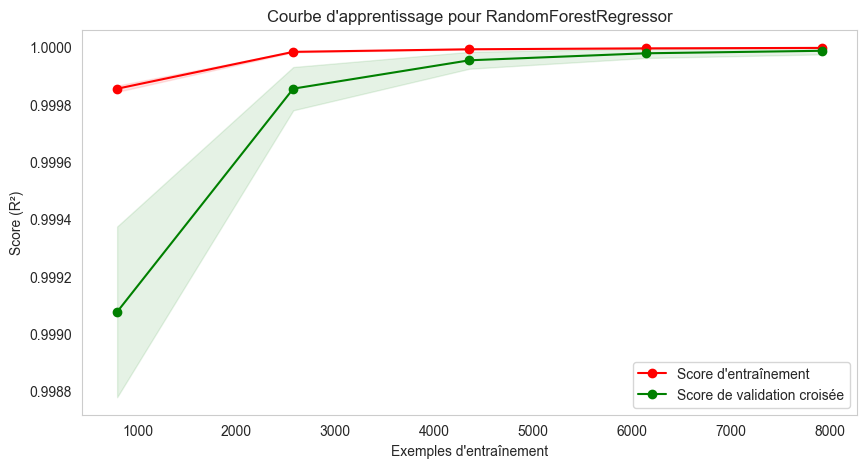

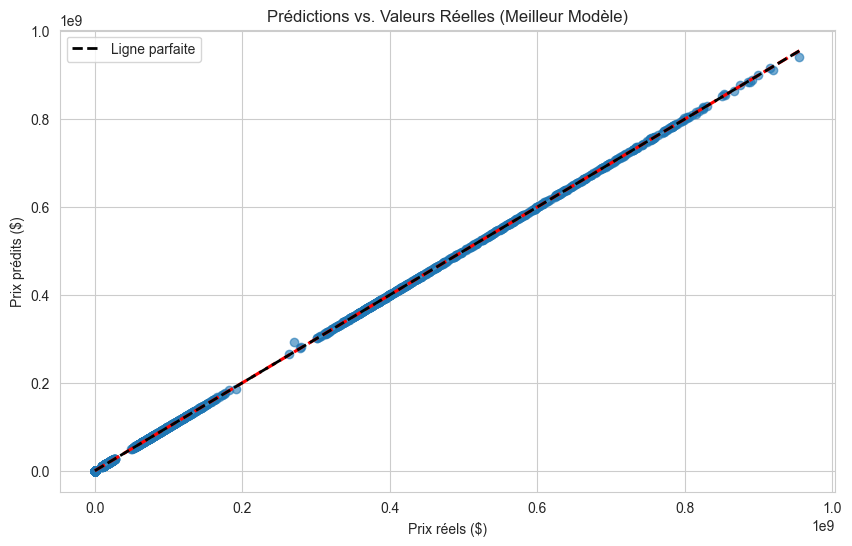

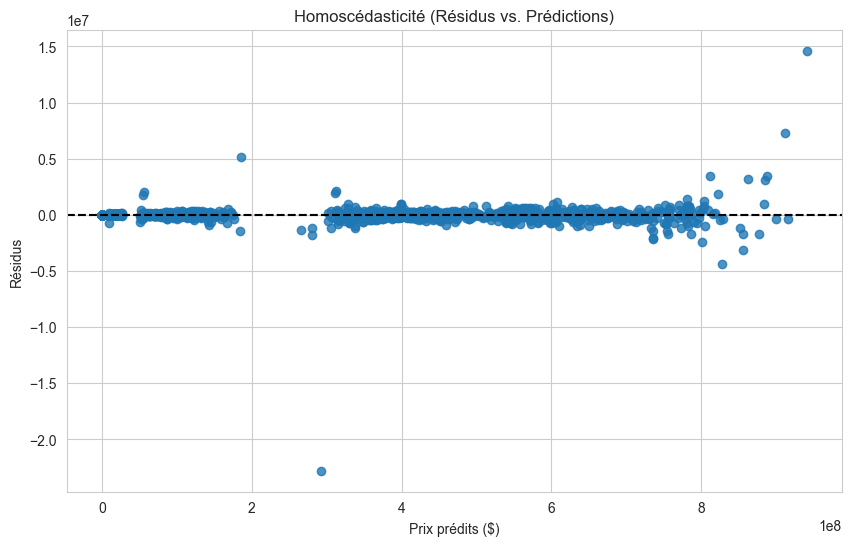

In [ ]:
# --- Visualisation des résultats du meilleur modèle ---

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Exemples d'entraînement")
    axes.set_ylabel("Score (R²)")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='r2', return_times=True
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1, color="g",
    )
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Score d'entraînement")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Score de validation croisée")
    axes.legend(loc="best")
    return plt

# Courbe d'apprentissage du meilleur modèle
plot_learning_curve(best_model, f"Courbe d'apprentissage pour {best_model.named_steps['regressor'].__class__.__name__}", X_train, y_train, cv=5)
plt.savefig("plots/airplane_price/learning_curve.png")
plt.show()

# Visualisation des prédictions vs. valeurs réelles
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_best, scatter_kws={'alpha':0.6}, line_kws={'color':'red', 'linestyle':'--'})
plt.xlabel("Prix réels ($)")
plt.ylabel("Prix prédits ($)")
plt.title("Prédictions vs. Valeurs Réelles (Meilleur Modèle)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ligne parfaite")
plt.legend()
plt.savefig("plots/airplane_price/predictions_vs_reels.png")
plt.show()

# Visualisation de l'homoscédasticité (résidus vs. prédictions)
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_best, y=residuals, line_kws={'color':'red', 'linestyle':'--'})

plt.xlabel("Prix prédits ($)")
plt.ylabel("Résidus")
plt.title("Homoscédasticité (Résidus vs. Prédictions)")
plt.axhline(y=0, color='k', linestyle='--')
plt.savefig("plots/airplane_price/homoscedasticity.png")
plt.show()

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy import stats
import joblib

In [72]:
# Chargement des données
data = pd.read_csv("data/airplane_price_dataset.csv")
print("Aperçu des données :")
display(data.head())
print(f"\nLignes: {data.shape[0]}, Colonnes: {data.shape[1]}")
print("\nInformations sur les données :")
display(data.info())
print("\nStatistiques descriptives :")
display(data.describe())

# Renommage des colonnes
data.rename(columns={
    "Model": "Modèle",
    "Üretim Yılı": "Année de production",
    "Motor Sayısı": "Nombre de moteurs",
    "Motor Türü": "Type de moteur",
    "Kapasite": "Capacité",
    "Menzil (km)": "Autonomie (km)",
    "Yakıt Tüketimi (L/saat)": "Consommation de carburant (L/h)",
    "Saatlik Bakım Maliyeti ($)": "Coût de maintenance horaire ($)",
    "Yaş": "Âge",
    "Satış Bölgesi": "Région de vente",
    "Fiyat ($)": "Prix ($)"
}, inplace=True)

print("Colonnes du DataFrame :", data.columns.tolist())

Aperçu des données :


,Model,Üretim Yılı,Motor Sayısı,Motor Türü,Kapasite,Menzil (km),Yakıt Tüketimi (L/saat),Saatlik Bakım Maliyeti ($),Yaş,Satış Bölgesi,Fiyat ($)
0,Bombardier CRJ200,1987,2,Turbofan,50,3000,14.36,2185.43,36,Asya,1.285708e+07
1,Bombardier CRJ200,1997,2,Turbofan,50,3000,4.03,1202.08,26,Avrupa,1.391406e+07
2,Airbus A320,1988,2,Turbofan,180,6300,13.26,761.38,35,Avustralya,9.073570e+07
3,Boeing 737,2023,2,Turbofan,162,5700,14.61,592.63,0,Avustralya,1.366597e+08
4,Cessna 172,1985,1,Piston,4,1285,18.49,4245.99,38,Güney Amerika,2.037981e+05



Lignes: 12377, Colonnes: 11

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12377 entries, 0 to 12376
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Model                       12377 non-null  object 
 1   Üretim Yılı                 12377 non-null  int64  
 2   Motor Sayısı                12377 non-null  int64  
 3   Motor Türü                  12377 non-null  object 
 4   Kapasite                    12377 non-null  int64  
 5   Menzil (km)                 12377 non-null  int64  
 6   Yakıt Tüketimi (L/saat)     12377 non-null  float64
 7   Saatlik Bakım Maliyeti ($)  12377 non-null  float64
 8   Yaş                         12377 non-null  int64  
 9   Satış Bölgesi               12377 non-null  object 
 10  Fiyat ($)                   12377 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ MB


None


Statistiques descriptives :


,Üretim Yılı,Motor Sayısı,Kapasite,Menzil (km),Yakıt Tüketimi (L/saat),Saatlik Bakım Maliyeti ($),Yaş,Fiyat ($)
count,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,1.237700e+04
mean,2001.477660,1.835259,190.413994,7782.210148,12.075615,2744.089599,21.522340,1.988336e+08
std,12.766785,0.370962,142.662710,5492.478746,9.905418,1293.209611,12.766785,2.290392e+08
min,1980.000000,1.000000,4.000000,1285.000000,2.000000,500.020000,0.000000,1.458148e+05
25%,1990.000000,2.000000,50.000000,3000.000000,5.950000,1627.260000,10.000000,1.409681e+07
50%,2001.000000,2.000000,162.000000,5700.000000,9.820000,2744.330000,22.000000,8.392191e+07
75%,2013.000000,2.000000,350.000000,14800.000000,13.470000,3848.840000,33.000000,3.843239e+08
max,2023.000000,2.000000,396.000000,15600.000000,49.970000,4999.660000,43.000000,9.782132e+08


Colonnes du DataFrame : ['Modèle', 'Année de production', 'Nombre de moteurs', 'Type de moteur', 'Capacité', 'Autonomie (km)', 'Consommation de carburant (L/h)', 'Coût de maintenance horaire ($)', 'Âge', 'Région de vente', 'Prix ($)']


In [73]:
# Détection des valeurs aberrantes avec l'IQR
def detect_outliers_iqr(df):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

outliers_iqr = detect_outliers_iqr(data)
print("\nDétection des valeurs aberrantes (IQR) :")
for col, outlier_values in outliers_iqr.items():
    print(f"Valeurs aberrantes dans {col} : {len(outlier_values)} valeurs")

# Détection des valeurs aberrantes avec le Z-score
def detect_outliers_zscore(df, threshold=3):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:
        z_scores = stats.zscore(df[col].dropna())
        outliers[col] = df[col][(z_scores > threshold) | (z_scores < -threshold)]
    return outliers

outliers_zscore = detect_outliers_zscore(data)
print("\nDétection des valeurs aberrantes (Z-score) :")
for col, outlier_values in outliers_zscore.items():
    print(f"Valeurs aberrantes dans {col} : {len(outlier_values)} valeurs")


Détection des valeurs aberrantes (IQR) :
Valeurs aberrantes dans Année de production : 0 valeurs
Valeurs aberrantes dans Nombre de moteurs : 2039 valeurs
Valeurs aberrantes dans Capacité : 0 valeurs
Valeurs aberrantes dans Autonomie (km) : 0 valeurs
Valeurs aberrantes dans Consommation de carburant (L/h) : 1286 valeurs
Valeurs aberrantes dans Coût de maintenance horaire ($) : 0 valeurs
Valeurs aberrantes dans Âge : 0 valeurs
Valeurs aberrantes dans Prix ($) : 4 valeurs

Détection des valeurs aberrantes (Z-score) :
Valeurs aberrantes dans Année de production : 0 valeurs
Valeurs aberrantes dans Nombre de moteurs : 0 valeurs
Valeurs aberrantes dans Capacité : 0 valeurs
Valeurs aberrantes dans Autonomie (km) : 0 valeurs
Valeurs aberrantes dans Consommation de carburant (L/h) : 422 valeurs
Valeurs aberrantes dans Coût de maintenance horaire ($) : 0 valeurs
Valeurs aberrantes dans Âge : 0 valeurs
Valeurs aberrantes dans Prix ($) : 23 valeurs


In [74]:
# Feature engineering
def engineer_features(data):
    df = data.copy()
    
    # Transformation logarithmique
    df['log_Prix'] = np.log1p(df['Prix ($)'])
    df['log_Consommation'] = np.log1p(df['Consommation de carburant (L/h)'])
    df['log_Cout_Maintenance'] = np.log1p(df['Coût de maintenance horaire ($)'])
    
    # Ratios importants
    df['Prix_par_siege'] = df['Prix ($)'] / df['Capacité']
    df['Efficacite'] = df['Autonomie (km)'] / df['Consommation de carburant (L/h)']
    
    return df

def create_categorical_features(data):
    df = data.copy()
    
    # Crée la colonne 'Catégorie_Capacité' basée sur la capacité
    bins = [0, 50, 150, 300, np.inf]
    labels = ['Petit', 'Moyen', 'Grand', 'Très Grand']
    df['Catégorie_Capacité'] = pd.cut(df['Capacité'], bins=bins, labels=labels, right=False)
    
    return df

# Application du feature engineering
data_engineered = engineer_features(data)
data_engineered = create_categorical_features(data_engineered)

In [75]:
# Préparation des features
numerical_features = [
    'Année de production', 'Nombre de moteurs', 'Capacité', 'Autonomie (km)',
    'log_Consommation', 'log_Cout_Maintenance', 'Âge', 'Prix_par_siege', 'Efficacite'
]
categorical_features = [
    'Modèle', 'Type de moteur', 'Région de vente', 'Catégorie_Capacité'
]

print(f"\nFeatures numériques : {numerical_features}")
print(f"Features catégorielles : {categorical_features}")

# Préparation des données
X = data_engineered.drop(['Prix ($)', 'log_Prix', 'Consommation de carburant (L/h)', 'Coût de maintenance horaire ($)'], axis=1)
y = data_engineered['Prix ($)']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Features numériques : ['Année de production', 'Nombre de moteurs', 'Capacité', 'Autonomie (km)', 'log_Consommation', 'log_Cout_Maintenance', 'Âge', 'Prix_par_siege', 'Efficacite']
Features catégorielles : ['Modèle', 'Type de moteur', 'Région de vente', 'Catégorie_Capacité']


In [76]:
# Préprocesseur pour le pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough'
)

In [ ]:
# Dictionnaires des modèles et des hyperparamètres à tester
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'DecisionTree': {'regressor__max_depth': [5, 10, 15]},
    'RandomForest': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [5, 10]},
    'GradientBoosting': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [3, 5]},
    'XGBoost': {
        'regressor__n_estimators': [200, 300],
        'regressor__max_depth': [5, 6],
        'regressor__learning_rate': [0.03, 0.05]
    }
}

best_model = None
best_score = float('inf')
results_summary = []
trained_models = {}

# Boucle pour entraîner et évaluer chaque modèle
print("\n" + "="*60)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES")
print("="*60)

for name, model in models.items():
    print(f"\n--- Entraînement du modèle : {name} ---")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    trained_models[name] = grid_search.best_estimator_
    
    y_pred = grid_search.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    print(f"Meilleurs paramètres pour {name}: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    results_summary.append({
        'Modèle': name,
        'Meilleurs Paramètres': grid_search.best_params_,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MAPE': mape
    })
    
    if rmse < best_score:
        best_score = rmse
        best_model = grid_search.best_estimator_

# Affichage du résumé des résultats
results_df = pd.DataFrame(results_summary).sort_values(by='R²', ascending=False)
print("\n" + "="*60)
print("RÉSUMÉ DES RÉSULTATS")
print("="*60)
display(results_df.to_string(index=False))

# Comparaison des moyennes des métriques
display(f"\nLe meilleur modèle est : {best_model.named_steps['regressor'].__class__.__name__}")


ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

--- Entraînement du modèle : LinearRegression ---
Meilleurs paramètres pour LinearRegression: {}
RMSE: 16503880.34, R²: 0.9949, MAE: 12834322.47, MAPE: 542.24%

--- Entraînement du modèle : Ridge ---
Meilleurs paramètres pour Ridge: {'regressor__alpha': 0.1}
RMSE: 16504097.42, R²: 0.9949, MAE: 12833911.82, MAPE: 541.95%

--- Entraînement du modèle : Lasso ---


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.342e+17, tolerance: 5.169e+16
  model = cd_fast.enet_coordinate_descent(


Meilleurs paramètres pour Lasso: {'regressor__alpha': 10.0}
RMSE: 16503876.23, R²: 0.9949, MAE: 12834322.11, MAPE: 542.24%

--- Entraînement du modèle : DecisionTree ---
Meilleurs paramètres pour DecisionTree: {'regressor__max_depth': 10}
RMSE: 948294.89, R²: 1.0000, MAE: 349651.30, MAPE: 0.23%

--- Entraînement du modèle : RandomForest ---
Meilleurs paramètres pour RandomForest: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}
RMSE: 650846.57, R²: 1.0000, MAE: 149539.41, MAPE: 0.09%

--- Entraînement du modèle : GradientBoosting ---
Meilleurs paramètres pour GradientBoosting: {'regressor__max_depth': 5, 'regressor__n_estimators': 200}
RMSE: 849255.21, R²: 1.0000, MAE: 428576.54, MAPE: 0.99%

--- Entraînement du modèle : XGBoost ---
Meilleurs paramètres pour XGBoost: {'regressor__learning_rate': 0.03, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
RMSE: 2779375.73, R²: 0.9999, MAE: 1031536.69, MAPE: 31.01%

RÉSUMÉ DES RÉSULTATS
          Modèle                  

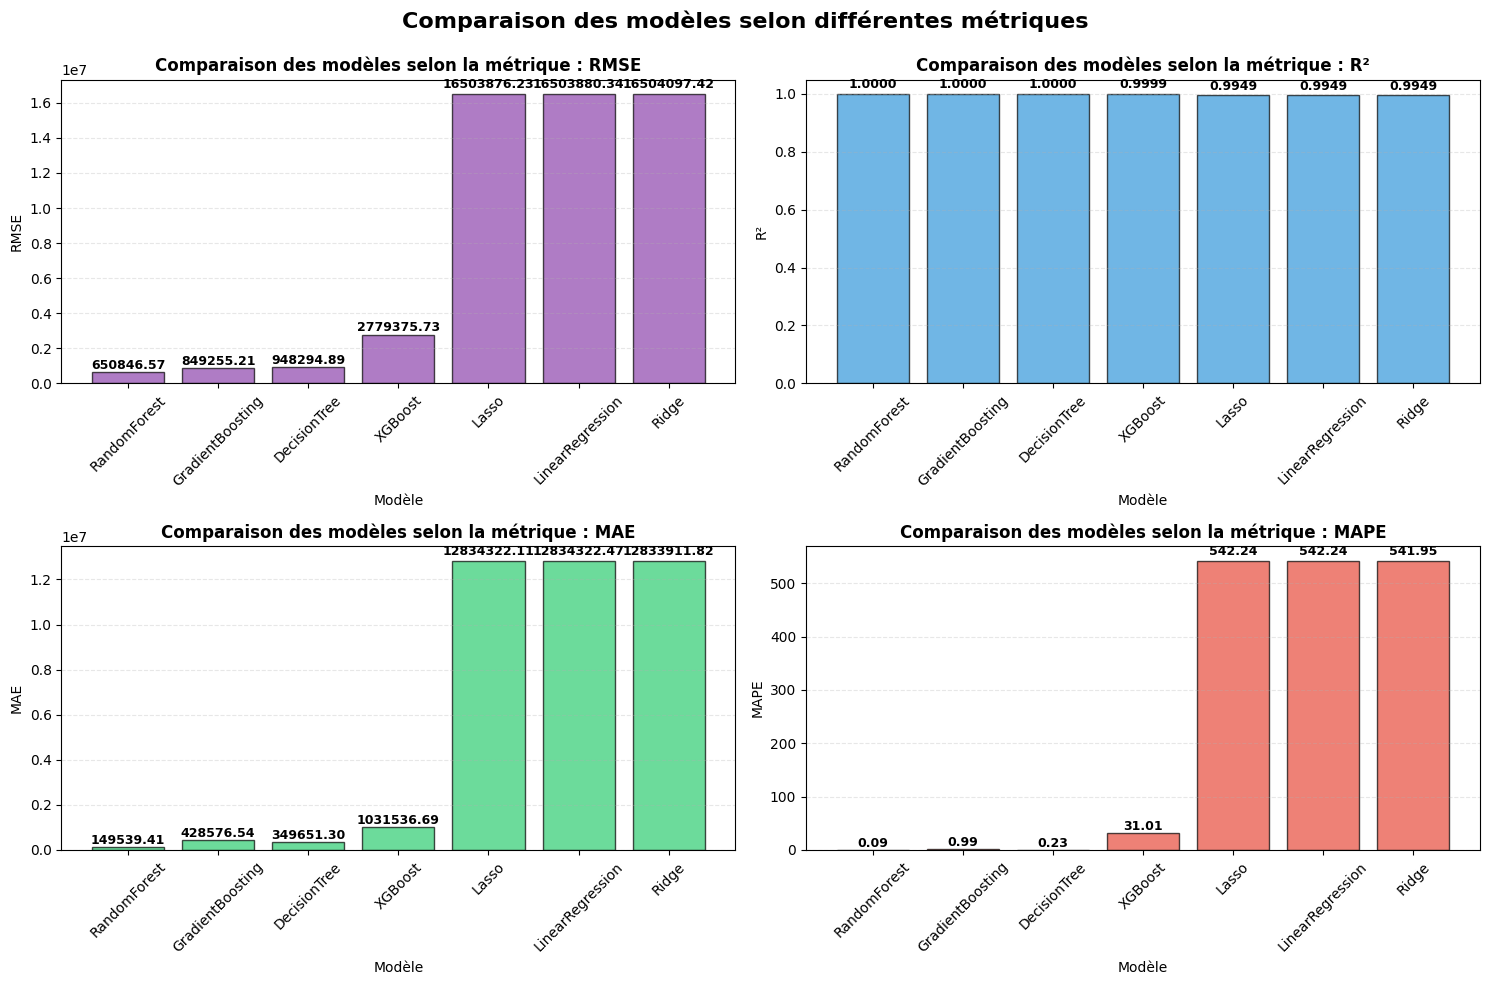

In [78]:
# Graphiques de comparaison des modèles
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparaison des modèles selon différentes métriques', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'R²', 'MAE', 'MAPE']
colors = ['#8E44AD', '#3498DB', '#2ECC71', '#E74C3C']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i//2, i%2]
    
    # Créer le graphique en barres
    bars = ax.bar(results_df['Modèle'], results_df[metric], color=color, alpha=0.7, edgecolor='black', linewidth=1)
    
    # Ajouter les valeurs au-dessus des barres
    for bar, value in zip(bars, results_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.2f}' if metric != 'R²' else f'{value:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax.set_title(f'Comparaison des modèles selon la métrique : {metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('Modèle')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("plots/airplane_price/models_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


IMPORTANCE DES FEATURES

--- Importance des features pour RandomForest ---
Top 10 features les plus importantes pour RandomForest :
                      Feature  Importance
Catégorie_Capacité_Très Grand    0.728440
               Prix_par_siege    0.125356
                     Capacité    0.077596
               Autonomie (km)    0.058986
     Catégorie_Capacité_Grand    0.006576
           Modèle_Airbus A350    0.001700
            Modèle_Boeing 777    0.000972
     Catégorie_Capacité_Petit    0.000082
            Modèle_Cessna 172    0.000064
        Type de moteur_Piston    0.000050


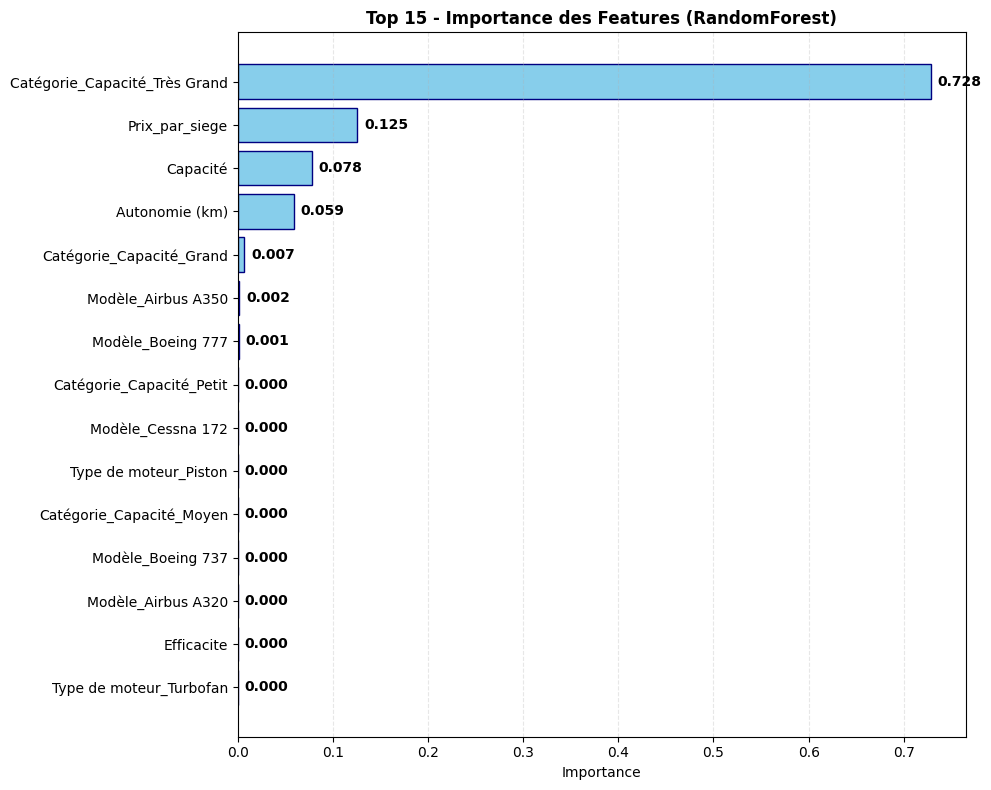


--- Importance des features pour GradientBoosting ---
Top 10 features les plus importantes pour GradientBoosting :
                      Feature  Importance
Catégorie_Capacité_Très Grand    0.352847
                     Capacité    0.304967
               Autonomie (km)    0.206789
               Prix_par_siege    0.126691
     Catégorie_Capacité_Grand    0.005547
           Modèle_Airbus A350    0.001876
            Modèle_Boeing 777    0.001187
            Modèle_Boeing 737    0.000050
           Modèle_Airbus A320    0.000042
                   Efficacite    0.000001


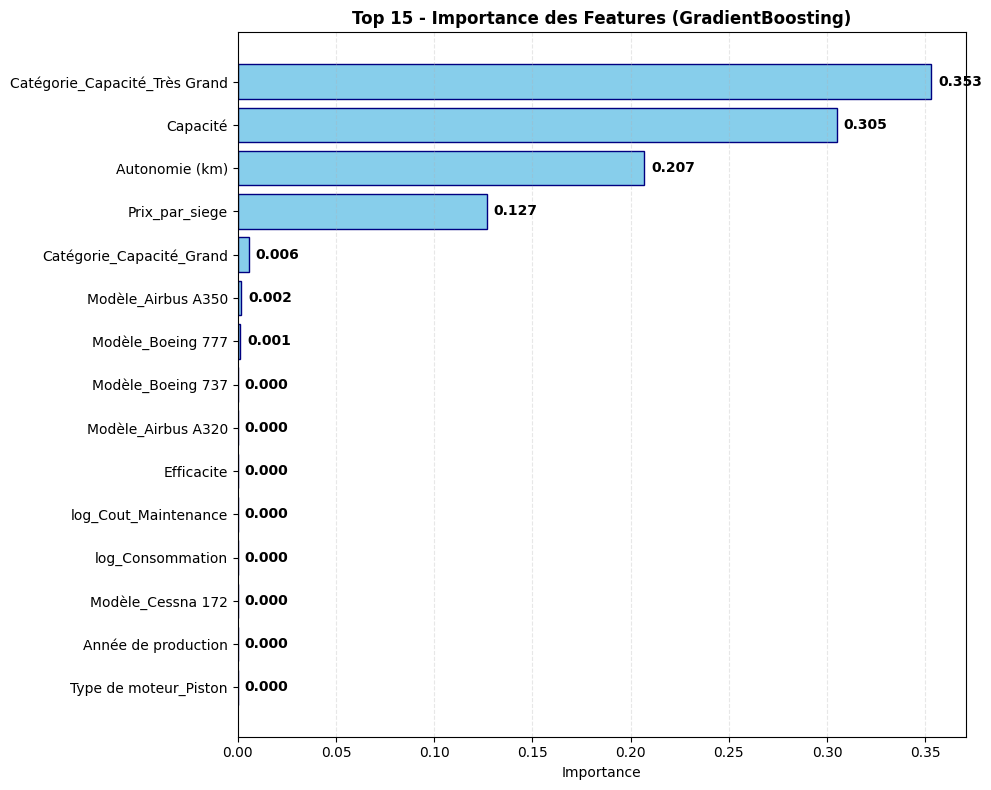


--- Importance des features pour XGBoost ---
Top 10 features les plus importantes pour XGBoost :
                   Feature  Importance
                  Capacité    0.921208
            Prix_par_siege    0.073284
         Nombre de moteurs    0.004415
Région de vente_Avustralya    0.000378
       Année de production    0.000132
    Région de vente_Afrika    0.000126
      log_Cout_Maintenance    0.000117
                Efficacite    0.000078
  Catégorie_Capacité_Grand    0.000077
        Modèle_Airbus A320    0.000055


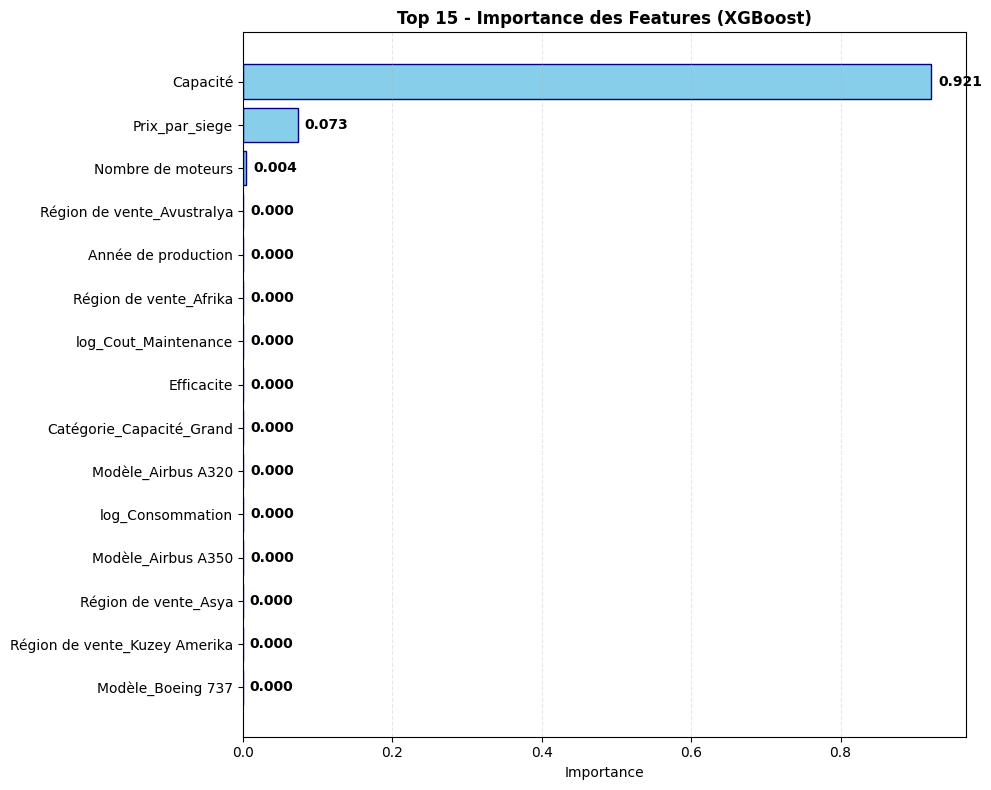


--- Importance des features pour DecisionTree ---
Top 10 features les plus importantes pour DecisionTree :
                      Feature  Importance
Catégorie_Capacité_Très Grand    0.847178
               Prix_par_siege    0.124733
     Catégorie_Capacité_Grand    0.022163
           Modèle_Airbus A350    0.003934
            Modèle_Boeing 777    0.001072
               Autonomie (km)    0.000400
     Catégorie_Capacité_Petit    0.000375
                     Capacité    0.000072
           Modèle_Airbus A320    0.000061
            Modèle_Boeing 737    0.000008


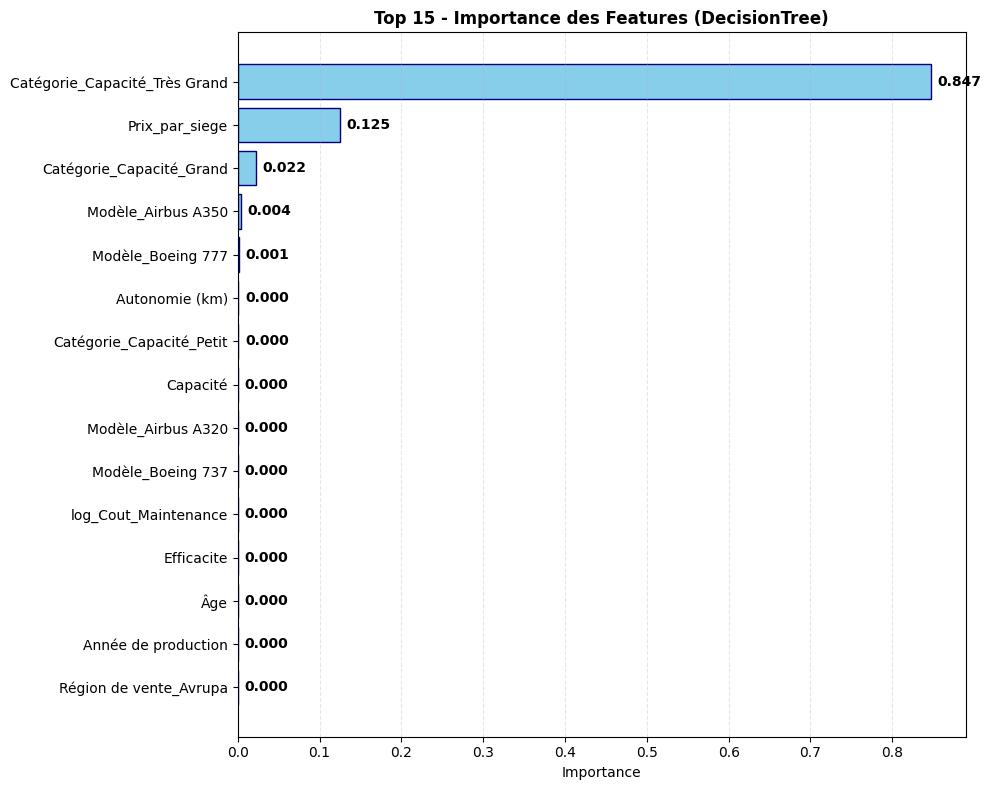

In [80]:
# Analyse de l'importance des features pour les modèles qui le supportent
print("\n" + "="*60)
print("IMPORTANCE DES FEATURES")
print("="*60)

def get_feature_names(preprocessor, X):
    """Récupère les noms des features après préprocessing"""
    feature_names = []
    
    # Features numériques
    num_features = numerical_features
    feature_names.extend(num_features)
    
    # Features catégorielles (après OneHotEncoding)
    cat_transformer = preprocessor.named_transformers_['cat']
    if hasattr(cat_transformer, 'get_feature_names_out'):
        cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
    else:
        # Pour les versions plus anciennes de scikit-learn
        cat_feature_names = []
        for i, cat_feature in enumerate(categorical_features):
            categories = cat_transformer.categories_[i]
            for category in categories:
                cat_feature_names.append(f"{cat_feature}_{category}")
    
    feature_names.extend(cat_feature_names)
    
    return feature_names

# Obtenir les noms des features
fitted_preprocessor = best_model.named_steps['preprocessor']
feature_names = get_feature_names(fitted_preprocessor, X_train)

# Analyse de l'importance pour différents modèles
models_with_importance = ['RandomForest', 'GradientBoosting', 'XGBoost', 'DecisionTree']

for model_name in models_with_importance:
    if model_name in trained_models:
        print(f"\n--- Importance des features pour {model_name} ---")
        
        model = trained_models[model_name]
        regressor = model.named_steps['regressor']
        
        if hasattr(regressor, 'feature_importances_'):
            importances = regressor.feature_importances_
            
            # Créer un DataFrame avec les importances
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"Top 10 features les plus importantes pour {model_name} :")
            print(feature_importance_df.head(10).to_string(index=False))
            
            # Graphique de l'importance des features (top 15)
            plt.figure(figsize=(10, 8))
            top_features = feature_importance_df.head(15)
            
            bars = plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue', edgecolor='navy')
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Importance')
            plt.title(f'Top 15 - Importance des Features ({model_name})', fontweight='bold')
            plt.gca().invert_yaxis()
            
            # Ajouter les valeurs à côté des barres
            for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
                plt.text(bar.get_width() + max(top_features['Importance']) * 0.01, bar.get_y() + bar.get_height()/2,
                        f'{importance:.3f}', ha='left', va='center', fontweight='bold')
            
            plt.grid(axis='x', linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.savefig(f"plots/airplane_price/feature_importance_{model_name.lower()}.png", dpi=300, bbox_inches='tight')
            plt.show()

In [81]:

# Analyse des coefficients pour les modèles linéaires
linear_models = ['LinearRegression', 'Ridge', 'Lasso']

for model_name in linear_models:
    if model_name in trained_models:
        print(f"\n--- Coefficients pour {model_name} ---")
        
        model = trained_models[model_name]
        regressor = model.named_steps['regressor']
        
        if hasattr(regressor, 'coef_'):
            coefficients = regressor.coef_
            
            # Créer un DataFrame avec les coefficients
            coef_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coefficients
            })
            coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
            coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
            
            print(f"Top 10 coefficients les plus importants (en valeur absolue) pour {model_name} :")
            print(coef_df[['Feature', 'Coefficient']].head(10).to_string(index=False))


--- Coefficients pour LinearRegression ---
Top 10 coefficients les plus importants (en valeur absolue) pour LinearRegression :
                      Feature   Coefficient
               Prix_par_siege  2.067004e+08
            Modèle_Boeing 777  3.336664e+07
            Nombre de moteurs -2.157852e+07
           Modèle_Airbus A350 -2.150346e+07
     Catégorie_Capacité_Grand -2.011473e+07
               Autonomie (km)  1.651179e+07
                     Capacité  1.566133e+07
           Modèle_Airbus A320 -1.347220e+07
Catégorie_Capacité_Très Grand  1.186318e+07
                          Âge  8.042101e+06

--- Coefficients pour Ridge ---
Top 10 coefficients les plus importants (en valeur absolue) pour Ridge :
                      Feature   Coefficient
               Prix_par_siege  2.066789e+08
            Modèle_Boeing 777  3.336370e+07
            Nombre de moteurs -2.157606e+07
           Modèle_Airbus A350 -2.149655e+07
     Catégorie_Capacité_Grand -2.011655e+07
               Aut

In [87]:
# Sauvegarde du meilleur modèle
joblib.dump(best_model, "models/airplane_price/best_airplane_price_model.pkl")
print(f"\nLe meilleur modèle ({best_model.named_steps['regressor'].__class__.__name__}) a été sauvegardé sous 'best_airplane_price_model.pkl'")


Le meilleur modèle (RandomForestRegressor) a été sauvegardé sous 'best_airplane_price_model.pkl'



VISUALISATIONS POUR LE MEILLEUR MODÈLE


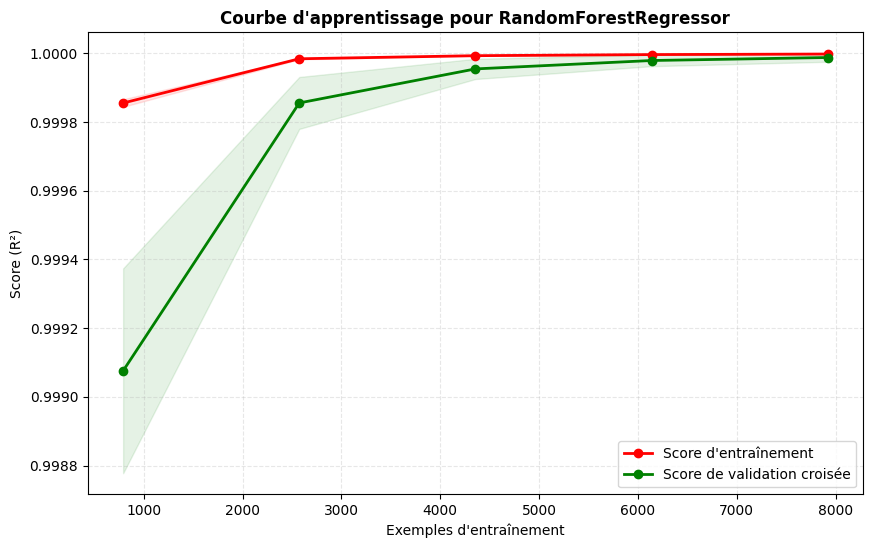

In [83]:

# Visualisation des résultats du meilleur modèle
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    
    axes.set_title(title, fontweight='bold')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Exemples d'entraînement")
    axes.set_ylabel("Score (R²)")
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='r2', return_times=True
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    axes.grid(True, linestyle='--', alpha=0.3)
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1, color="g",
    )
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Score d'entraînement", linewidth=2)
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Score de validation croisée", linewidth=2)
    axes.legend(loc="best")
    return plt

# Courbe d'apprentissage du meilleur modèle
print("\n" + "="*60)
print("VISUALISATIONS POUR LE MEILLEUR MODÈLE")
print("="*60)

plot_learning_curve(best_model, f"Courbe d'apprentissage pour {best_model.named_steps['regressor'].__class__.__name__}", X_train, y_train, cv=5)
plt.savefig("plots/airplane_price/learning_curve.png", dpi=300, bbox_inches='tight')
plt.show()

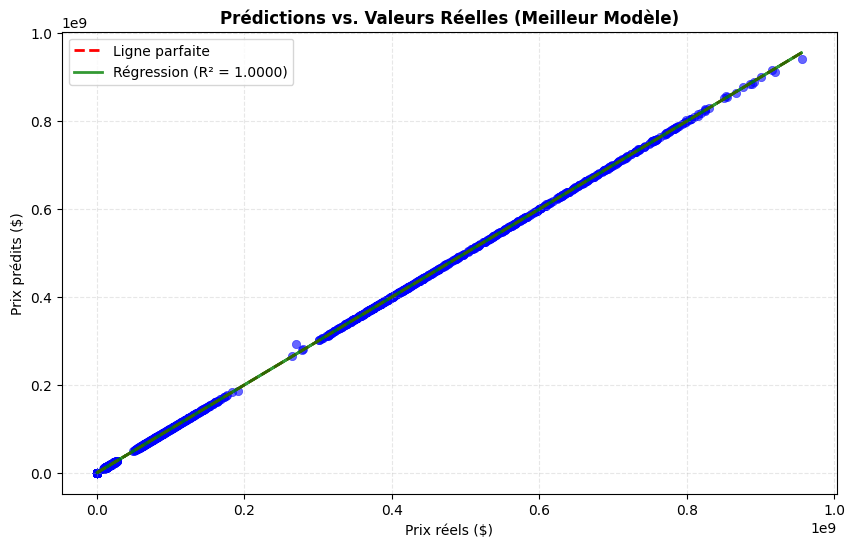

In [89]:
# Visualisation des prédictions vs. valeurs réelles
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ligne parfaite")

# Ligne de régression
z = np.polyfit(y_test, y_pred_best, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "g-", alpha=0.8, linewidth=2, label=f"Régression (R² = {r2_score(y_test, y_pred_best):.4f})")

plt.xlabel("Prix réels ($)")
plt.ylabel("Prix prédits ($)")
plt.title("Prédictions vs. Valeurs Réelles (Meilleur Modèle)", fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plots/airplane_price/predictions_vs_reels.png", dpi=300, bbox_inches='tight')
plt.show()

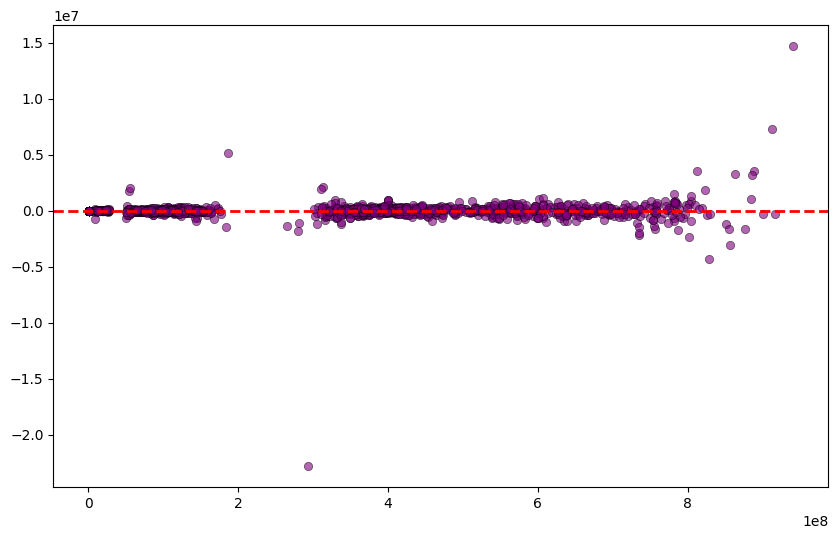

In [85]:
# Visualisation de l'homoscédasticité (résidus vs. prédictions)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.6, color='purple', edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

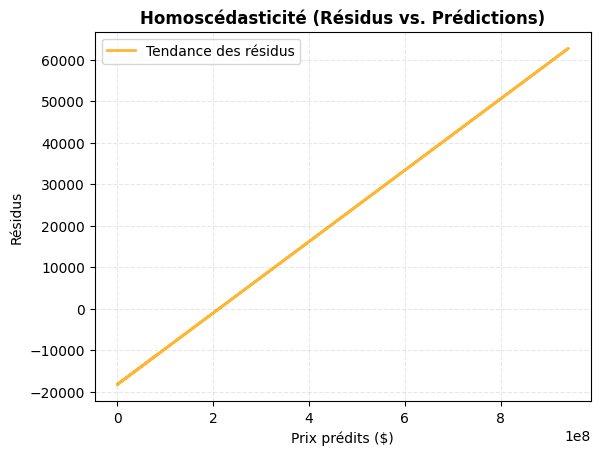


ANALYSE TERMINÉE
Tous les graphiques ont été sauvegardés dans le dossier 'plots/airplane_price/'
Le meilleur modèle a été sauvegardé sous 'best_airplane_price_model.pkl'


In [ ]:
# Ligne de tendance des résidus
z = np.polyfit(y_pred_best, residuals, 1)
p = np.poly1d(z)
plt.plot(y_pred_best, p(y_pred_best), "orange", alpha=0.8, linewidth=2, label="Tendance des résidus")

plt.xlabel("Prix prédits ($)")
plt.ylabel("Résidus")
plt.title("Homoscédasticité (Résidus vs. Prédictions)", fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plots/airplane_price/homoscedasticity.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("ANALYSE TERMINÉE")
print("="*60)
print("Tous les graphiques ont été sauvegardés dans le dossier 'plots/airplane_price/'")
print("Le meilleur modèle a été sauvegardé sous 'models/airplane_price/best_airplane_price_model.pkl'")